In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=True)

client

Client Scheduler: tcp://127.0.0.1:61871 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [3]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


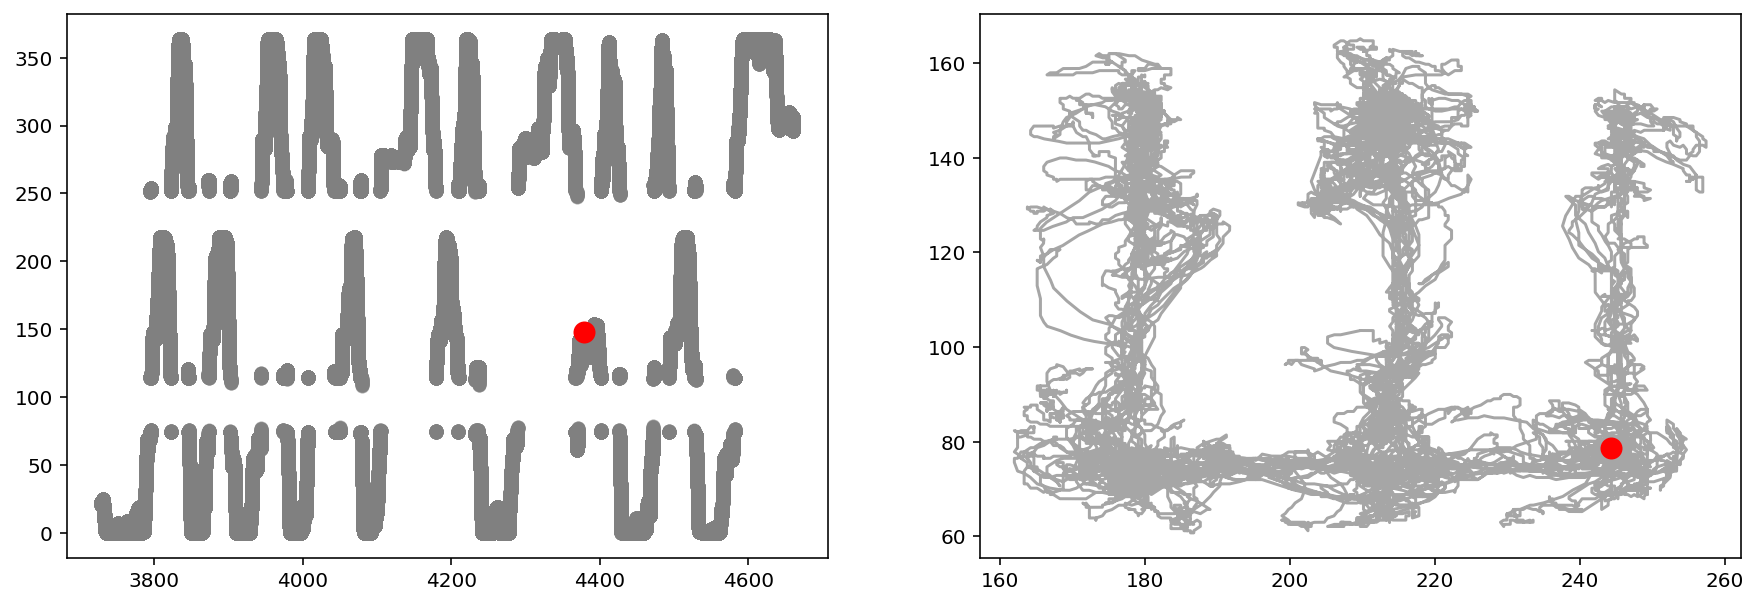

In [4]:
from ipywidgets import interact

position_info = data['position_info']

def _plot_1D_2D(time_ind=0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].scatter(position_info.index.total_seconds().values, position_info.linear_position2,
                    color='grey', alpha=0.7)
    axes[0].scatter(position_info.index.total_seconds().values[time_ind],
                    position_info.linear_position2[time_ind], color='red', s=100)
    axes[1].plot(position_info.x_position, position_info.y_position, color='grey', alpha=0.7)
    axes[1].scatter(position_info.x_position[time_ind],
                    position_info.y_position[time_ind], color='red', s=100, zorder=10)

_plot_1D_2D(time_ind=325000)

In [153]:
from src.parameters import replay_speed, place_bin_size, movement_var, discrete_diag
from replay_trajectory_classification import SortedSpikesClassifier

position = position_info.linear_position2
track_labels = position_info.arm_name
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],
     ['uniform',   'uniform', 'uniform'],
     ['w_track_1D_random_walk', 'uniform', 'identity']])

classifier = SortedSpikesClassifier(
    place_bin_size=1.0, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=0.5, knot_spacing=10,
    continuous_transition_types=continuous_transition_types).fit(
    position, data['spikes'], is_training=is_training, track_labels=track_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


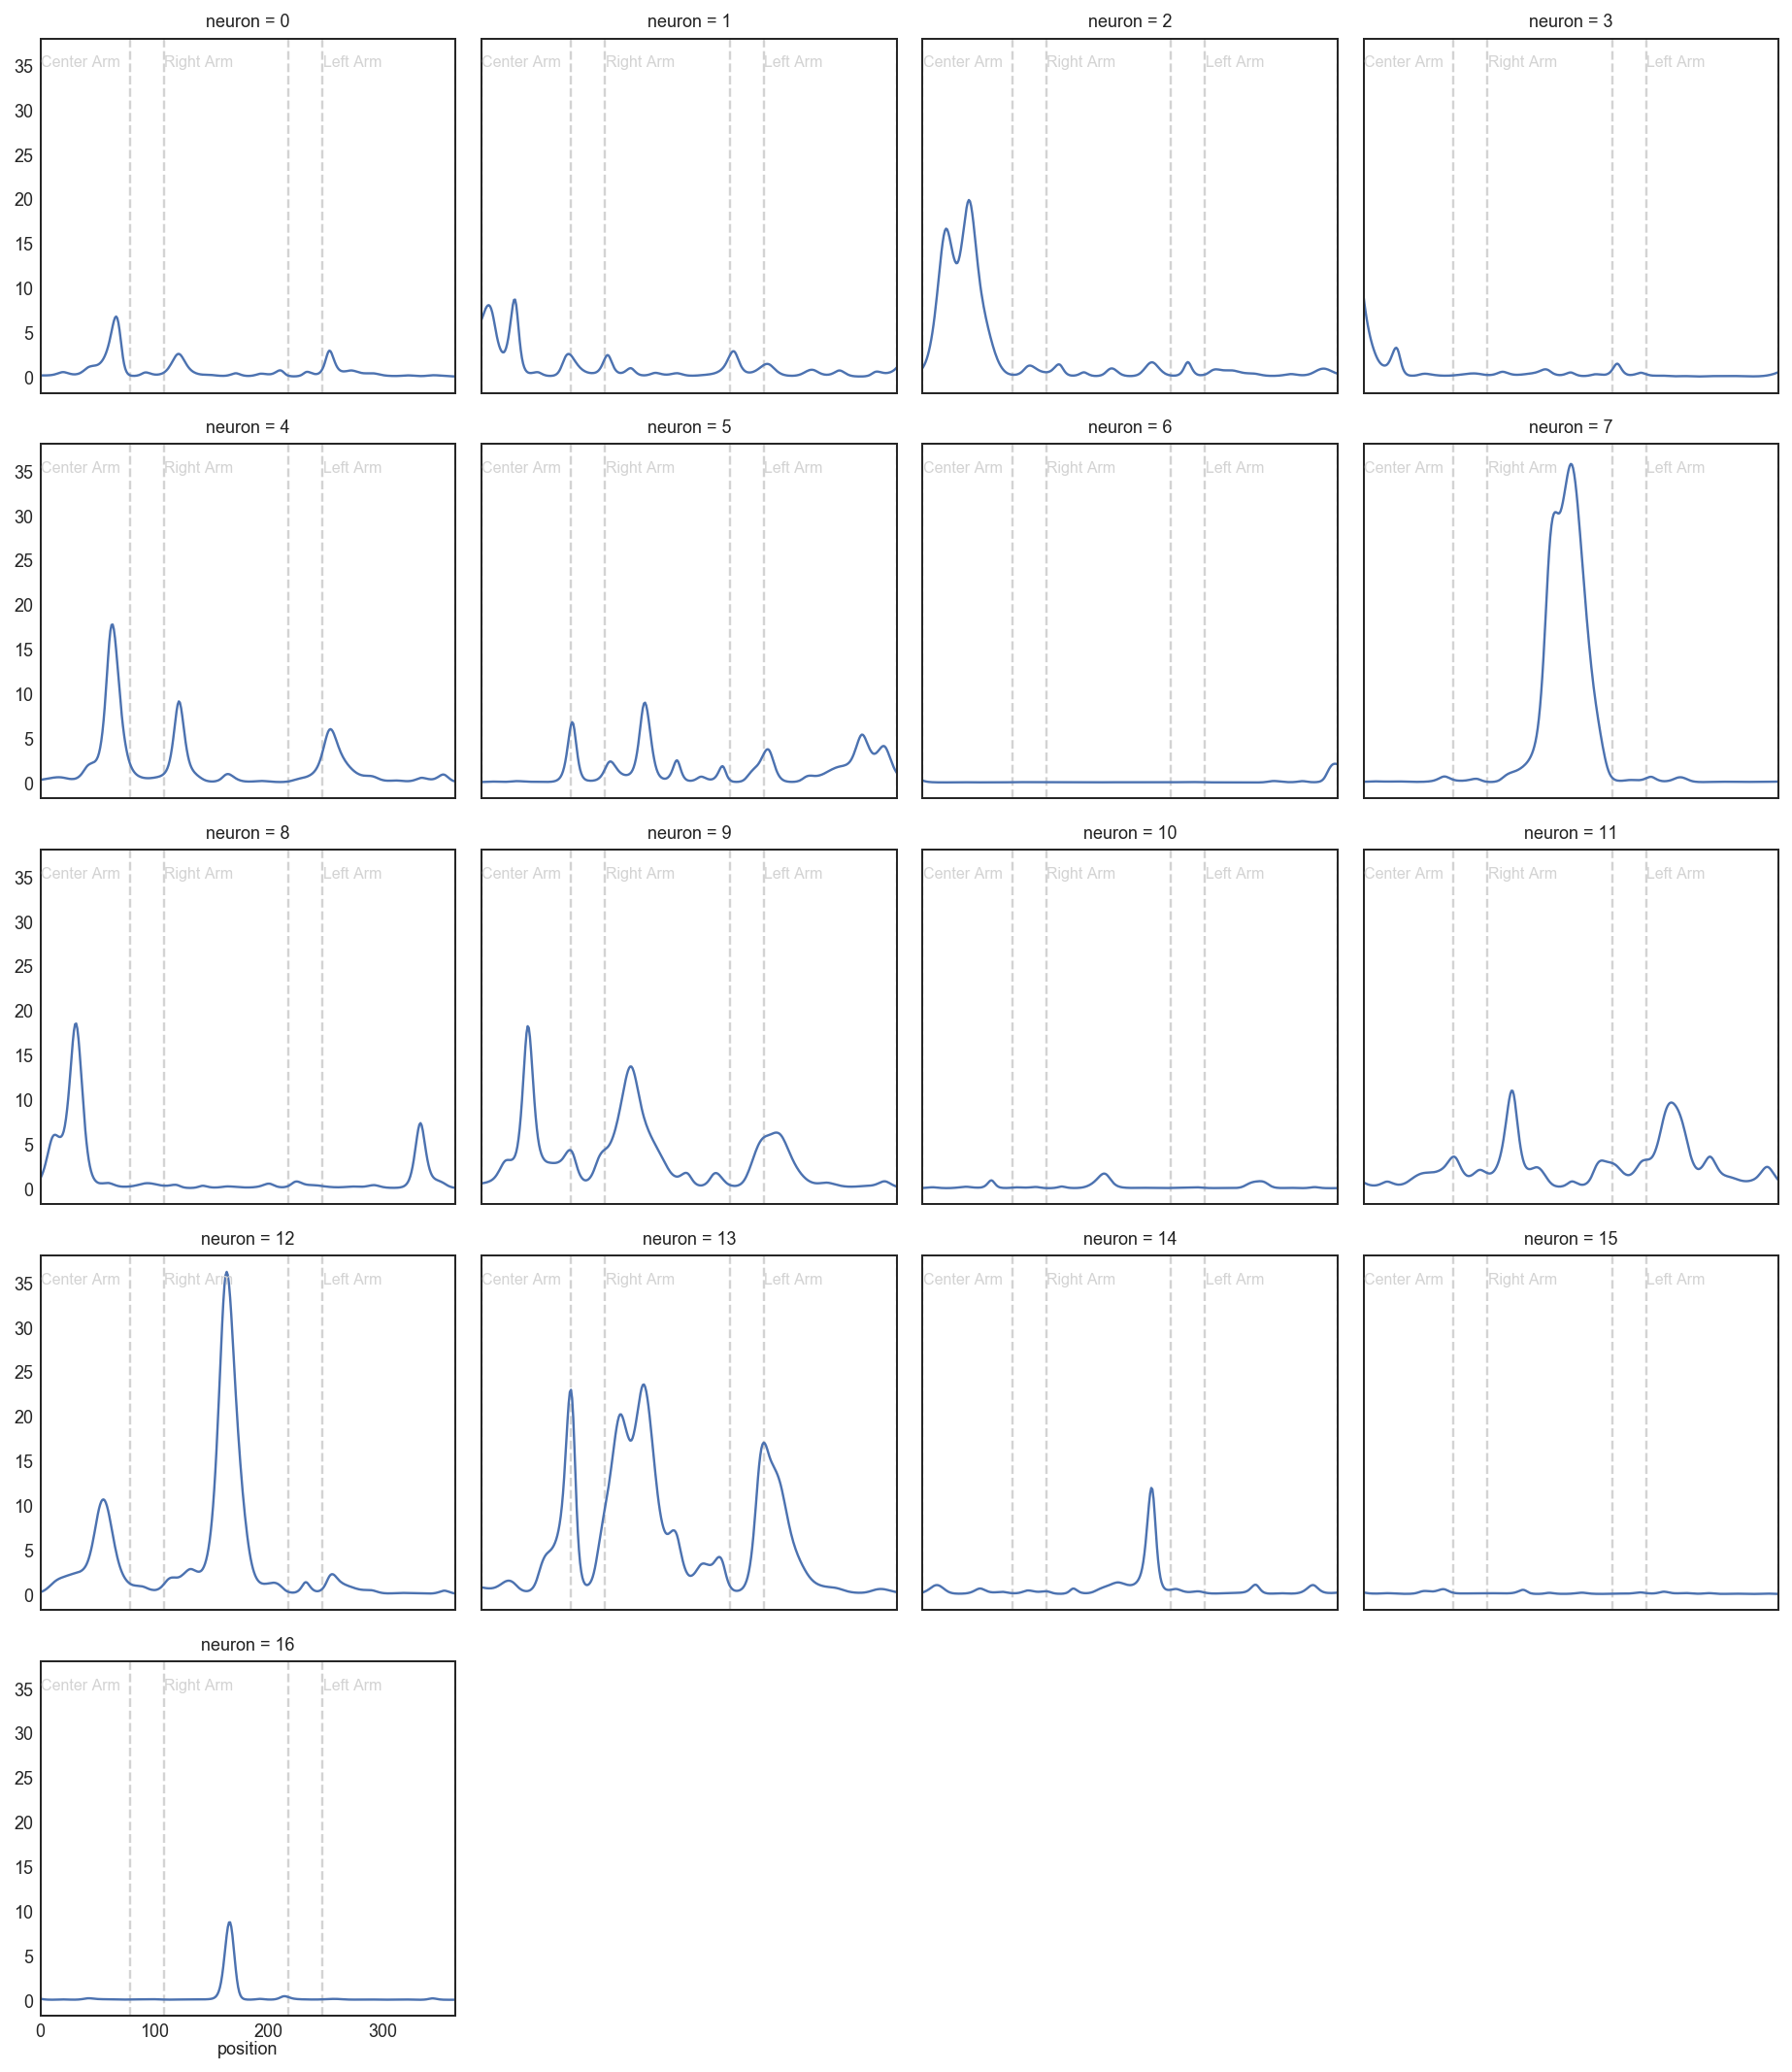

In [154]:
g = (classifier.place_fields_ * data['sampling_frequency']).plot(x='position', col='neuron', col_wrap=4)
max_df = position_info.groupby('arm_name').linear_position2.max()
min_df = position_info.groupby('arm_name').linear_position2.min()
plt.xlim((0, position_info.linear_position2.max()))
max_rate = classifier.place_fields_.values.max() * data['sampling_frequency']
for ax in g.axes.flat:
    for arm_name, min_position in min_df.iteritems():
        ax.axvline(min_position, color='lightgrey', zorder=0,
                   linestyle='--')
        ax.text(min_position + 0.2, max_rate, arm_name, color='lightgrey',
                horizontalalignment='left', verticalalignment='top',
                fontsize=8)
    for arm_name, max_position in max_df.iteritems():
        ax.axvline(max_position, color='lightgrey', zorder=0,
                   linestyle='--')


In [155]:
from loren_frank_data_processing import reshape_to_segments

ripple_spikes = reshape_to_segments(
    data['spikes'], data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=data['sampling_frequency'])

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=data['sampling_frequency'])

In [156]:
from src.analysis import get_linear_position_order, get_place_field_max
from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS
from src.figure_utilities import set_figure_defaults, TWO_COLUMN, GOLDEN_RATIO
import seaborn as sns


set_figure_defaults()

def plot_classification(test_spikes, results, position_info):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY),
        time=lambda ds: 1000.0 * result.time / np.timedelta64(1, 's')
    )
    place_field_max = get_place_field_max(classifier)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(test_spikes[:, linear_position_order])
    replay_time = results.time.values
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 7), constrained_layout=True, sharex=True)
    
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=20, linewidth=1)
    axes[0].set_yticks((1, test_spikes.shape[1]))
    axes[0].set_xticks([])
    axes[0].set_xlim((replay_time.min(), replay_time.max()))
    axes[0].set_ylabel('Cells')
    
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=2, label=state,
                color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_xticks([])
    axes[1].set_xlim((replay_time.min(), replay_time.max()))
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.30, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Pos. [cm]')
    axes[2].set_xlim((replay_time.min(), replay_time.max()))
    axes[2].set_xticks((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    
    max_df = position_info.groupby('arm_name').linear_position2.max()
    min_df = position_info.groupby('arm_name').linear_position2.min()
    axes[2].set_ylim((0, position_info.linear_position2.max()))
    axes[2].set_yticks((0, position_info.linear_position2.max()))
    
    max_df = (position_info
              .groupby('arm_name').linear_position2.max())
    min_time = replay_time.min()
    for arm_name, max_position in max_df.iteritems():
        axes[2].axhline(max_position, color='grey',
                        linestyle='-', linewidth=1)
        axes[2].text(min_time, max_position - 5, arm_name, color='white',
                     fontsize=8, verticalalignment='top')
    min_df = (position_info
              .groupby('arm_name').linear_position2.min())
    for arm_name, min_position in min_df.iteritems():
        axes[2].axhline(min_position, color='grey',
                        linestyle='-', linewidth=1)
    
    sns.despine()

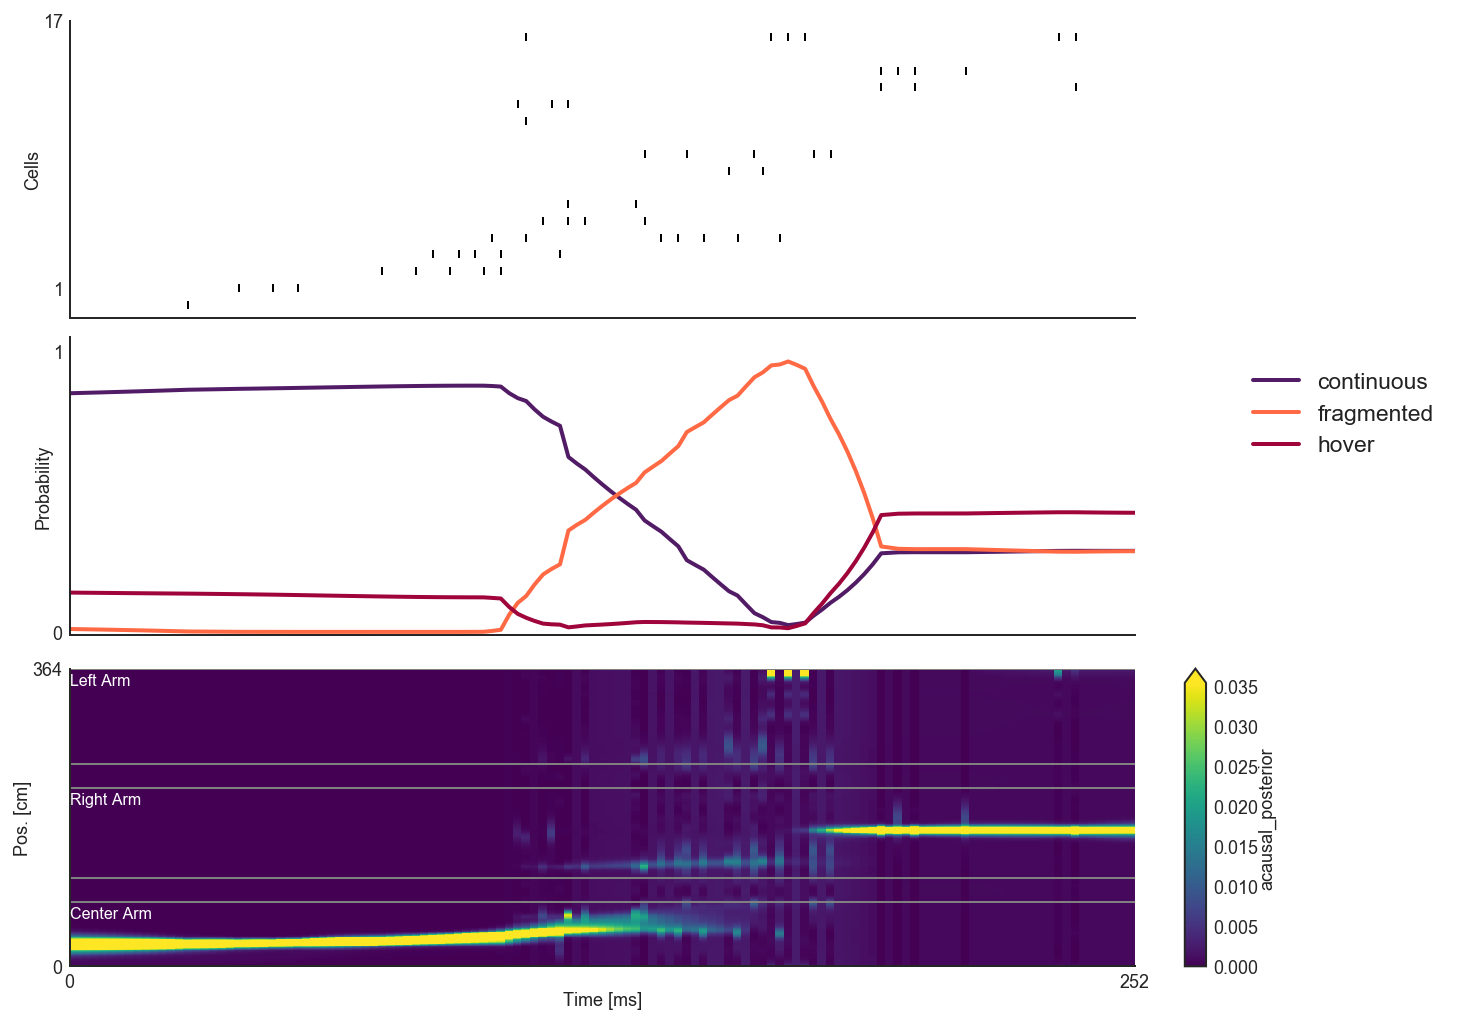

In [158]:
ripple_number = 145

result = classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)

plot_classification(ripple_spikes.loc[ripple_number].values, result, data['position_info'])

In [145]:
from src.parameters import replay_speed, place_bin_size, movement_var, discrete_diag, model, model_kwargs
from replay_trajectory_classification import ClusterlessClassifier

position = position_info.linear_position2
track_labels = position_info.arm_name
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],
     ['uniform',   'uniform', 'uniform'],
     ['w_track_1D_random_walk', 'uniform', 'identity']])

classifier = ClusterlessClassifier(
    place_bin_size=1.0, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
    position, data['multiunit'], is_training=is_training, track_labels=track_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


In [151]:
ripple_number = 145
time_slice = slice(*data['ripple_times'].loc[
    ripple_number, ['start_time', 'end_time']])
m = data['multiunit'].sel(time=time_slice)
result = classifier.predict(m, m.time - m.time[0])


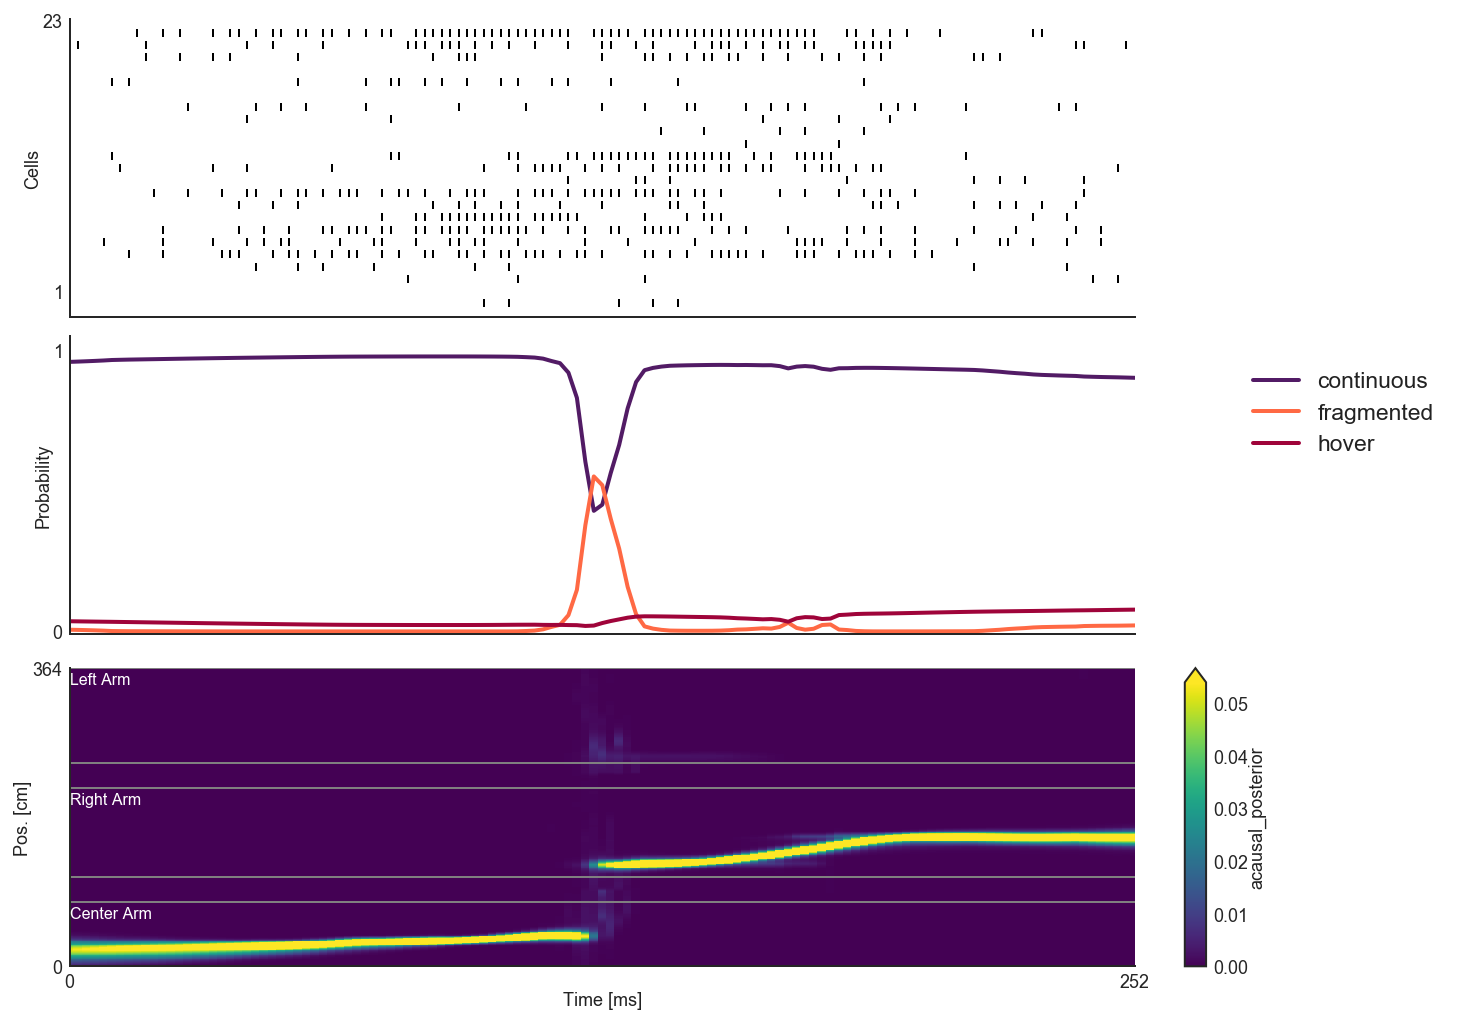

In [152]:
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)
plot_classification(ripple_spikes.loc[ripple_number].values, result, data['position_info'])